# Spark Straming Pipeline 

Showing how stitching can be done on spark streaming environment.

### Input Images
Input images are taken from demo image source, which generates shifted, overlapping stripes from cameraman images.

Streaming is added to this source by creating a stream indicating that an image is available for using. 

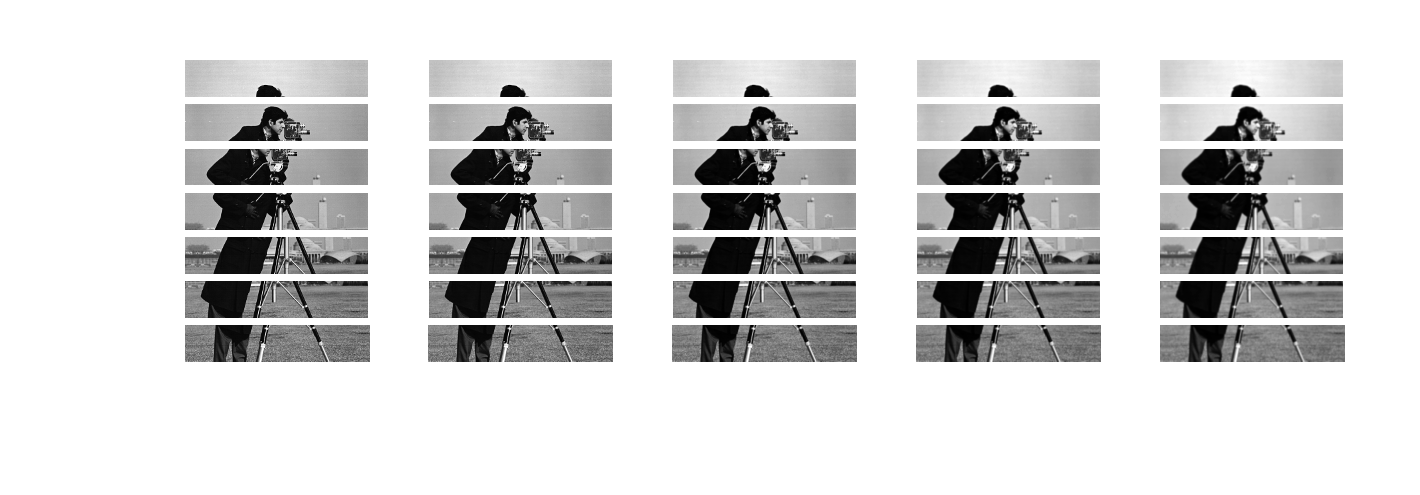

In [1]:
stripe_count = 7
version_count = 5

demo_image_source_args = {
    "stripe_count": stripe_count,
    "version_count": version_count,
    "channel_count": 1,
    "vertical_shifts": (19, 38, 0),
    "overlap": 0.4,
}

from alpenglow.image_sources.demo import DemoImageSource
image_source = DemoImageSource(**demo_image_source_args)

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3.8, 1), dpi=400)

for version_id in range(version_count):
    for stripe_id in range(stripe_count):
        ax = fig.add_subplot(stripe_count, version_count, 1 + version_id + version_count * stripe_id)
        ax.imshow(image_source.get_image(stripe_id, version_id), cmap='gray')
        ax.set_axis_off()
plt.show()

### Initializing spark context

This notebook is using spark streaming engine for computation. Spark is running on local machine. 

Defining checkpointing dir is required by ussage of stateful operations. In production a hadoop directory should be used instead.

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

sc = SparkContext("local[2]", "AlpenglowPipeline2")
sc.setCheckpointDir("/tmp/spark")
ssc = StreamingContext(sc, 1)

### Demo imput stream

Input stream consists of pairs: version_id, stripe_id. Occurrence of element in the stream indicates that image of given version in given stripe is ready for download.

Note: In demo input source images are auto-generated. In real-life use cases images at some point will become available at aws s3 bucket.

In [3]:
input_data = [sc.parallelize([(version_id, stripe_id) for version_id in range(version_count)]) for stripe_id in range(stripe_count)]
input_stream = ssc.queueStream(input_data)

## Shift detection

Shift detection is a process of finding out how two consecutive strips (layers) were shifted, and how much they overlap. For shift detections only limited number of versions (cross sections) is used.

It consist of steps:
1. Sampling
2. Fetching sample images
3. Matching pairs from consecutive stripes
4. calculating stats between pairs
5. Aggregating stats
6. Extracting shift and overlay from stats
7. Calculate image positions

In [4]:
# Sampling

N = 3

# filter accepting N versions evently distributed in [0, version_count)
def select_N(x):
    if N == 1: # accept middle one
        return x[0] == version_count // 2
    elif N == 2: # accept edges
        return x[0] == 0 or x[0] == version_count - 1
    else:
        return (x[0] == 0) or (((x[0] + 1) * (N - 1)) % version_count) == 0 or (x[0] + 1) * (N - 1) // version_count > x[0] * (N-1) // version_count

sampled_input_stream = input_stream.filter(select_N)

In [5]:
# Fetching sampled images

# Note: in real life use case Image source (connection) should be reused.
def getImage(record):
    image_source = DemoImageSource(**demo_image_source_args)
    image = image_source.get_image(record[1], record[0])
    return (record[0], (record[1], image))

sampled_image_stream = sampled_input_stream.map(getImage)

In [6]:
# Matching pairs from consecutive stripes

def joinConsecutiveStripes(stripes, state):
    if state is None:
        state = ([], {}, {}, min(stripe[0] for stripe in stripes))
        
    ready = []
    waiting_previous = state[1]
    waiting_next = state[2]
    first_stripe = state[3]
    
    for stripe in stripes:
        stripe_id = stripe[0]
        if stripe_id > first_stripe:
            if (stripe_id - 1) in waiting_next:
                previous_stripe = waiting_next[(stripe_id - 1)]
                del waiting_next[(stripe_id - 1)]
                ready.append((previous_stripe, stripe))
            else:
                waiting_previous[stripe_id] = stripe
        
        if (stripe_id + 1) in waiting_previous:
            next_stripe = waiting_previous[(stripe_id + 1)]
            del waiting_previous[(stripe_id + 1)]
            ready.append((stripe, next_stripe))
        else:
            waiting_next[stripe_id] = stripe

    return (ready, waiting_previous, waiting_next, first_stripe)

pair_state_stream = sampled_image_stream.updateStateByKey(joinConsecutiveStripes)
image_pair_stream = pair_state_stream.flatMap(lambda x: x[1][0])

In [7]:
# calculating stats between pairs

import numpy

def cross_correlation(top_image, bottom_image):
    src_image = numpy.array(top_image, dtype=numpy.complex128, copy=False)
    target_image = numpy.array(bottom_image, dtype=numpy.complex128, copy=False)
    src_freq = numpy.fft.fftn(src_image)
    target_freq = numpy.fft.fftn(target_image)

    image_product = src_freq * target_freq.conj()

    return numpy.fft.ifftn(image_product)

def countCorrelations(stripes):
    stripe_id = stripes[0][0]
    top_image = stripes[0][1]
    bottom_image = stripes[1][1]
    
    width = min(top_image.shape[1], bottom_image.shape[1])
    height = min(top_image.shape[0], bottom_image.shape[0]) // 2
    
    return stripe_id, (cross_correlation(top_image[-height:, :width], bottom_image[:height, :width]), top_image.shape, bottom_image.shape)

correlations_parts_stream = image_pair_stream.map(countCorrelations)

In [8]:
# Aggregating stats

def sumCorrelations(correlations, currentSum):
    if currentSum is None:
        return (sum([c[0] for c in correlations]), len(correlations), correlations[0][1], correlations[0][2])
    elif len(correlations) == 0 and currentSum[1] == N: # removes matrix from state if it was alredy written.
        return None
    return (currentSum[0] + sum([c[0] for c in correlations]), currentSum[1] + len(correlations), currentSum[2], currentSum[3])

correlations_stream = correlations_parts_stream.updateStateByKey(sumCorrelations).filter(lambda x: x[1][1] == N)

In [9]:
# Extracting shift and overlay from stats

def findShift(value):
    stripe_id = value[0]
    correlation = value[1][0]
    shape = correlation.shape
    
    midpoints = numpy.array([numpy.fix(axis_size / 2) for axis_size in shape])
    maxima = numpy.unravel_index(numpy.argmax(numpy.abs(correlation)), correlation.shape)
    shifts = numpy.array(maxima, dtype=numpy.int)

    shifts[shifts > midpoints] -= numpy.array(shape)[shifts > midpoints]
    shifts[0] = shape[0] - shifts[0]

    return (stripe_id, (list(shifts), value[1][2], value[1][3]))

shift_stream = correlations_stream.map(findShift)

In [10]:
# Calculate image positions

margin = 30 # number of pixcels added on left and right in first stip to 

def merge_shifts(shifts, shiftState):
    if shiftState is None:
        shiftState = ([], 0, {}, margin, 0, 0, None)
    ready, current, shift_buffer, x, y, printed, width = shiftState
    ready = []
    
    for shift in shifts:
        stripe_id = shift[0]
        shift_buffer[stripe_id] = shift[1]
        
    while current in shift_buffer:
        shift, top_shape, bottom_shape = shift_buffer[current]
        del shift_buffer[current]
        
        if width is None: 
            width = top_shape[1] + 2 * margin
        
        ready.append((current, ((y, x), printed, shift, width)))
        x += shift[1]
        
        if x < 0 or x + bottom_shape[1] > width:
            raise ValueError('Vertical shift {0} out of range [0, {1})'.format(x, width))

        y += top_shape[0] - shift[0]
        printed = shift[0]
        
        current += 1

    return (ready, current, shift_buffer, x, y, printed, width)

stripe_positions = shift_stream.map(lambda x: (0, x)).updateStateByKey(merge_shifts).flatMap(lambda x: x[1][0])

## Apply detected shifts to image stream

In [11]:
from alpenglow.patchwork_builders.default import PatchworkBuilder

all_shifts = stripe_positions.flatMap(lambda x: [(version_id, ('shift', x[0], x[1])) for version_id in range(version_count)])
all_images = input_stream.map(getImage).map(lambda x: (x[0], ('image', x[1][0], x[1][1])))

def joinImages(images, state):
    if state is None:
        state = ([], 0, {}, {})
        
    _, current, image_buffer, metadata_buffer = state
    ready = []
    
    for data in images:
        if data[0] == 'shift':
            metadata_buffer[data[1]] = data[2]
        else:
            image_buffer[data[1]] = data[2]
            
    while (current in metadata_buffer) and (current in image_buffer) and ((current + 1) in image_buffer):
        position, top_skip, shift, width = metadata_buffer[current]
        top_image = image_buffer[current]
        bottom_image = image_buffer[current + 1][0:shift[0], :]
        
        del image_buffer[current]
        del metadata_buffer[current]
        
        height = top_image.shape[0] - top_skip
        data = numpy.zeros((height, width), dtype=top_image.dtype)
        data[0:height, position[1]:(position[1] + top_image.shape[1])] = top_image[top_skip:, :]
        
        bottom_x = position[1] + shift[1]
        print("x position: {0}, next: {1}".format(position[1], bottom_x))
        data[-shift[0]:, bottom_x:(bottom_x + bottom_image.shape[1])] = PatchworkBuilder.gradient_merge_arrays(data[-shift[0]:, bottom_x:(bottom_x + bottom_image.shape[1])], bottom_image)

        ready.append(data)
        
        current += 1
        
    return (ready, current, image_buffer, metadata_buffer)

shifted_images = all_images.union(all_shifts).updateStateByKey(joinImages).flatMap(lambda x: [(x[0], section) for section in x[1][0]])

In [12]:

%matplotlib inline
import matplotlib.pyplot as plt
import datetime

versions = {}

def print_rdd(rdd):
    for version_id, data in rdd.collect():
        if version_id in versions:
            versions[version_id] = numpy.concatenate((versions[version_id], data))
        else:
            versions[version_id] = data
            
    if len(versions) == 0:
        return

    fig = plt.figure(figsize=(3.8, 0.3), dpi=400)

    print('{0}'.format(datetime.datetime.utcnow()))   
    for version_id in range(version_count):
        if version_id in versions:
            ax = fig.add_subplot(1, version_count, 1 + version_id)
            ax.imshow(versions[version_id], cmap='gray')
            ax.set_axis_off()
         
    plt.show()

shifted_images.foreachRDD(print_rdd)

2018-07-22 20:16:36.206078


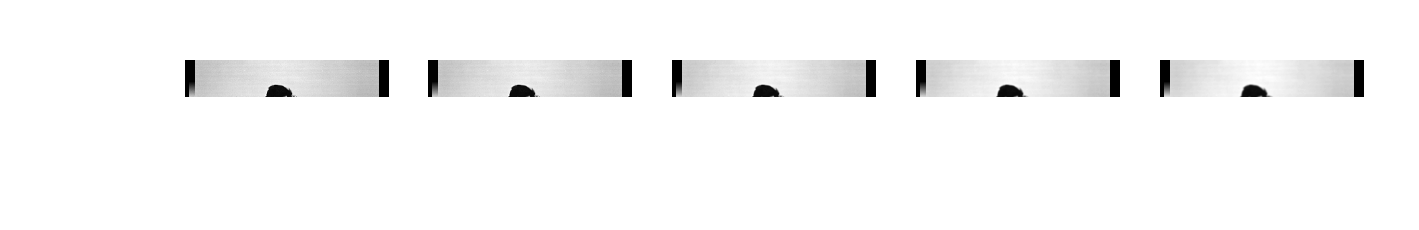

2018-07-22 20:16:38.666428


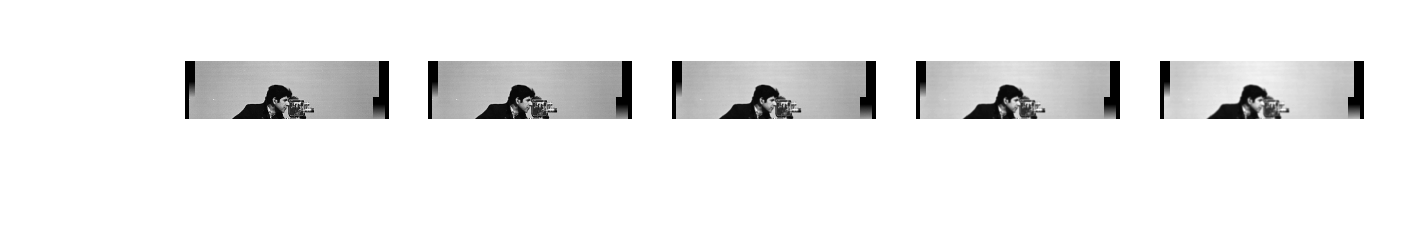

2018-07-22 20:16:39.730698


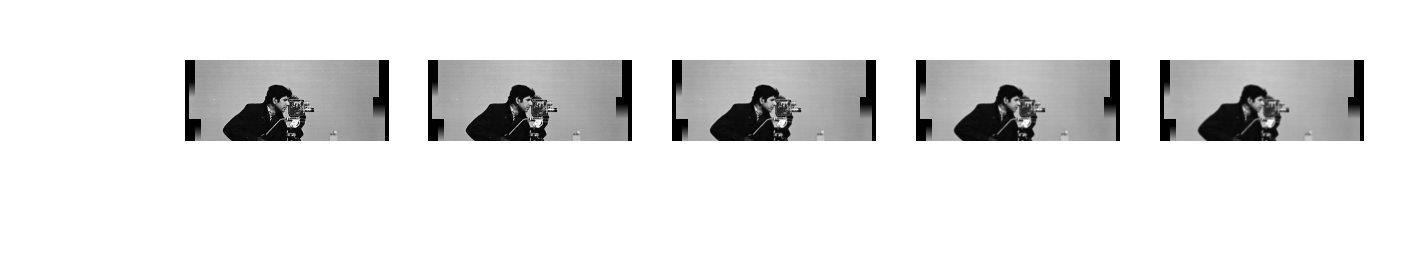

2018-07-22 20:16:41.117246


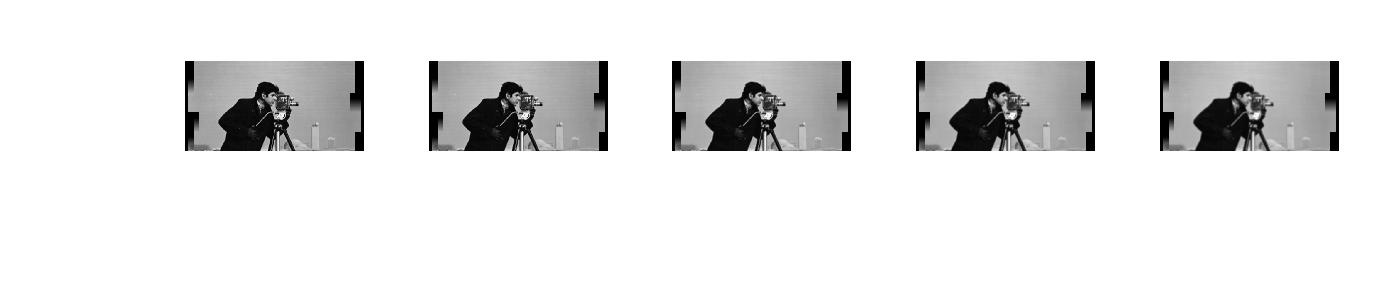

In [13]:
ssc.start()
ssc.awaitTermination(10)


2018-07-22 20:16:43.211832


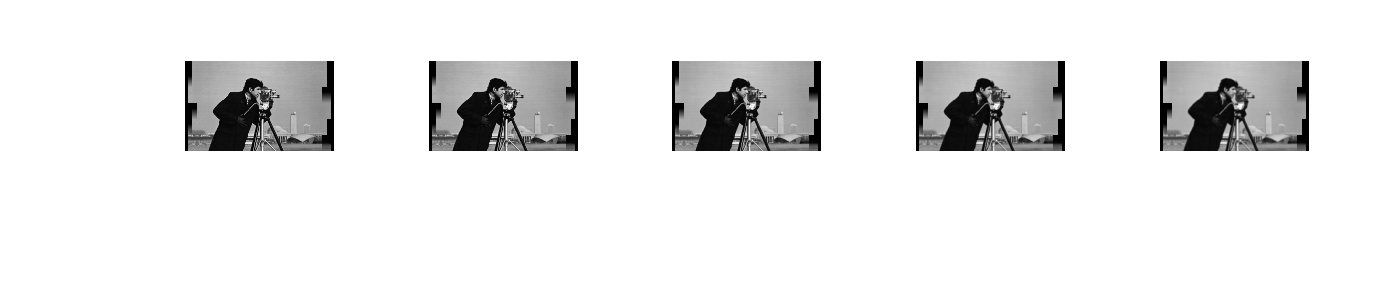

2018-07-22 20:16:44.260998


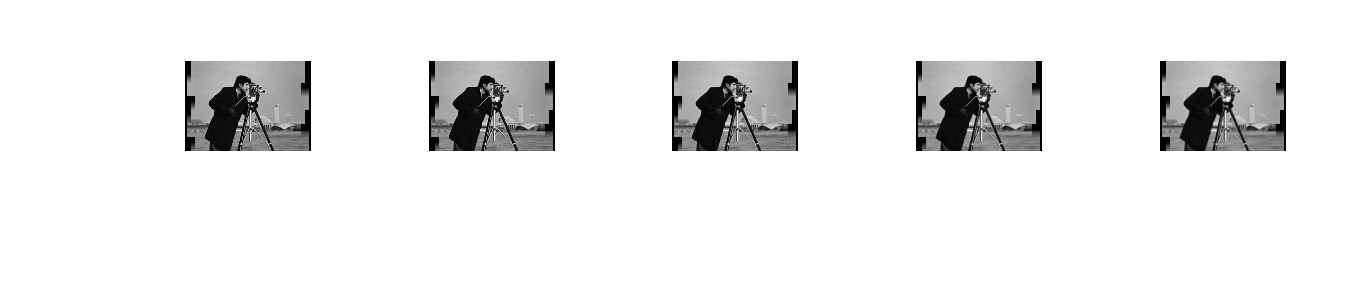

In [14]:
ssc.stop()
sc.stop()